**Obs: Importante frisar que os datasets utilizados ja estão balanceados e tratados, sendo o único tratamento feito, foi a exlusão dos outliers**

In [ ]:
#Ao executar a primeira vez, tem que instalar a biblioteca pyod

#!pip install pyod
!pip install pyod

**Importando as bibliotecas**

In [ ]:
import pandas as pd
from pyod.models.knn import KNN
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statistics as sts
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, classification_report, recall_score, precision_recall_curve

**Carregando as bases de dados**

In [ ]:
previsores_cvd = pd.read_csv('previsores_cvd.csv')
target_cvd = pd.read_csv('target_cvd.csv')

previsores_MI = pd.read_csv('previsores_MI.csv')
target_MI = pd.read_csv('target_MI.csv')

previsores_ANGINA = pd.read_csv('previsores_ANGINA.csv')
target_ANGINA = pd.read_csv('target_ANGINA.csv')

previsores_STROKE = pd.read_csv('previsores_STROKE.csv')
target_STROKE = pd.read_csv('target_STROKE.csv')

In [ ]:
previsores_cvd.shape, previsores_MI.shape, previsores_ANGINA.shape, previsores_STROKE.shape

((1310, 15), (1480, 15), (1458, 15), (1532, 15))

**Concatenando previsores e targets**

In [ ]:
#Nessa parte, será necessário concater a base previsores com target, visto que, nesse caso, a ideia é excluir os outlier
#Sendo assim, caso não faça isso, a quantidade de linhas de previsores e targets ficarão desiguais, causando erro na hora de implementar o train_test_split
#Por outro lado, caso for substituir os valores dos outliers, não é necessário concatenar.

previsores_cvd = pd.concat([previsores_cvd, target_cvd], verify_integrity=True, axis=1)

previsores_MI = pd.concat([previsores_MI, target_MI], verify_integrity=True, axis=1)

previsores_ANGINA = pd.concat([previsores_ANGINA, target_ANGINA], verify_integrity=True, axis=1)

previsores_STROKE = pd.concat([previsores_STROKE, target_STROKE], verify_integrity=True, axis=1)

**Detectando Outliers através da biblioteca pyod**

In [ ]:
#Cria o modelo e faz o ajuste nas bases previsores para detectar os outliers

detector_cvd = KNN()
detector_cvd.fit(previsores_cvd.iloc[:,0:15])

detector_MI = KNN()
detector_MI.fit(previsores_MI.iloc[:,0:15])

detector_ANGINA = KNN()
detector_ANGINA.fit(previsores_ANGINA.iloc[:,0:15])

detector_STROKE = KNN()
detector_STROKE.fit(previsores_STROKE.iloc[:,0:15])

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [ ]:
#Retorna um array de 0 e 1, onde 0 não é outlier e 1 é outlier

previsoes_outliers_cvd = detector_cvd.labels_

previsoes_outliers_MI = detector_MI.labels_

previsoes_outliers_ANGINA = detector_ANGINA.labels_

previsoes_outliers_STROKE = detector_STROKE.labels_

In [ ]:
#Retorna a soma de 0 e 1 que o detector localizou
#Com isso, também ja podemos saber a quantidade de outliers que existem no dataset

np.unique(previsoes_outliers_cvd, return_counts=True)

np.unique(previsoes_outliers_MI, return_counts=True)

np.unique(previsoes_outliers_ANGINA, return_counts=True)

np.unique(previsoes_outliers_STROKE, return_counts=True)

(array([0, 1]), array([1378,  154]))

In [ ]:
#Adiciona em uma lista, os índices das linhas que possuem outliers

outliers_previsores_cvd = []
for i in range(len(previsoes_outliers_cvd)):
  if previsoes_outliers_cvd[i] == 1:
    outliers_previsores_cvd.append(i)

outliers_previsores_MI = []
for i in range(len(previsoes_outliers_MI)):
  if previsoes_outliers_MI[i] == 1:
    outliers_previsores_MI.append(i)

outliers_previsores_ANGINA = []
for i in range(len(previsoes_outliers_ANGINA)):
  if previsoes_outliers_ANGINA[i] == 1:
    outliers_previsores_ANGINA.append(i)

outliers_previsores_STROKE = []
for i in range(len(previsoes_outliers_STROKE)):
  if previsoes_outliers_STROKE[i] == 1:
    outliers_previsores_STROKE.append(i)

In [ ]:
#Cria um DataFrame somente com as linhas que possuem outliers

#lista_outliers_previsores_cvd = previsores_cvd.iloc[outliers_previsores_cvd,:]

#lista_outliers_previsores_MI = previsores_MI.iloc[outliers_previsores_MI,:]

#lista_outliers_previsores_ANGINA = previsores_ANGINA.iloc[outliers_previsores_ANGINA,:]

#lista_outliers_previsores_STROKE = previsores_STROKE.iloc[outliers_previsores_STROKE,:]

In [ ]:
#Exlui as linhas que possuem outliers na base previsores

previsores_cvd = previsores_cvd.drop(outliers_previsores_cvd, axis=0)

previsores_MI = previsores_MI.drop(outliers_previsores_MI, axis=0)

previsores_ANGINA = previsores_ANGINA.drop(outliers_previsores_ANGINA, axis=0)

previsores_STROKE = previsores_STROKE.drop(outliers_previsores_STROKE, axis=0)

**Separando previsores e targets após exlusão dos outliers**

In [ ]:
target_cvd = previsores_cvd['cvd']
previsores_cvd = previsores_cvd.drop(['cvd'], axis=1)

target_MI = previsores_MI['MI']
previsores_MI = previsores_MI.drop(['MI'], axis=1)

target_ANGINA = previsores_ANGINA['ANGINA']
previsores_ANGINA = previsores_ANGINA.drop(['ANGINA'], axis=1)

target_STROKE = previsores_STROKE['STROKE']
previsores_STROKE = previsores_STROKE.drop(['STROKE'], axis=1)

**Detectando Outliers através do z-score**

In [ ]:
'''
outliers=[]

def find_outliers(data_set):
    corte_dp =3
    media = np.mean(data_set)
    dp =np.std(data_set)
    
    
    for dado in data_set:
        
        z_score = (dado - media)/dp 
        if np.abs(z_score) > corte_dp:
            outliers.append(dado)
            
    #print('Os outliers são: ', outliers)
    
    return outliers
'''

"\noutliers=[]\n\ndef find_outliers(data_set):\n    corte_dp =3\n    media = np.mean(data_set)\n    dp =np.std(data_set)\n    \n    \n    for dado in data_set:\n        \n        z_score = (dado - media)/dp \n        if np.abs(z_score) > corte_dp:\n            outliers.append(dado)\n            \n    #print('Os outliers são: ', outliers)\n    \n    return outliers\n"

**Detectando outliers através da amplitude_interquartil**

In [ ]:
#Q1, Q3 = np.percentile(previsores_STROKE['BTDIASM'] , [25 ,75])
#print('Primeiro Quartil ou Pecentil 25: ',Q1)
#print('Terciro quartil ou percentil 75  ',Q3)

In [ ]:
#Amp_interquartil = Q3 - Q1
#print(Amp_interquartil)

In [ ]:
# determinar o limite inferior e o limite superior
#limite_inferior = Q1 - (1.5 * Amp_interquartil)
#limite_superior = Q3 + (1.5 * Amp_interquartil)

#print('Limite Inferior: ',limite_inferior )
#print('Limite Superior: ',limite_superior )

**Separando as bases em treinamento e teste**

In [ ]:
#Separando base previsores e target_cvd

X_train_cvd, X_test_cvd, y_train_cvd, y_test_cvd = train_test_split(previsores_cvd, target_cvd, test_size = 0.20)

#Separando base previsores e target_MI

X_train_MI, X_test_MI, y_train_MI, y_test_MI = train_test_split(previsores_MI, target_MI, test_size = 0.20)

#Separando base previsores e target_ANGINA

X_train_ANGINA, X_test_ANGINA, y_train_ANGINA, y_test_ANGINA = train_test_split(previsores_ANGINA, target_ANGINA, test_size = 0.20)

#Separando base previsores e target_STROKE

X_train_STROKE, X_test_STROKE, y_train_STROKE, y_test_STROKE = train_test_split(previsores_STROKE, target_STROKE, test_size = 0.20)

**Instanciando o algoritmo RandomForestClassifier**

In [ ]:
modeloRandom = RandomForestClassifier()

**Treinando previsores_cvd / target_cvd com RandomForestClassifier**

In [ ]:
modeloRandom.fit(X_train_cvd, y_train_cvd)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
previsoes_cvd = modeloRandom.predict(X_test_cvd)

Text(24.0, 0.5, 'Resposta Certa')

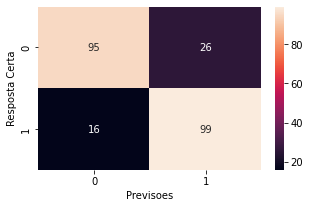

In [ ]:
matriz_cvd = confusion_matrix(y_test_cvd, previsoes_cvd)

plt.figure(figsize = (5,3))
sns.heatmap(matriz_cvd, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_cvd

TP_cvd = matriz_cvd[0,0]
TN_cvd = matriz_cvd[1,1]
FP_cvd = matriz_cvd[1,0]
FN_cvd = matriz_cvd[0,1]

#Accuracy previosres/target_cvd

Accuracy_cvd = accuracy_score(y_test_cvd, previsoes_cvd) * 100

#F1_Score previsores/target_cvd

F1_cvd = f1_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_cvd

MCC_cvd = matthews_corrcoef(y_test_cvd, previsoes_cvd) * 100

# Sensitivity previsores/target_cvd

sensitivity = recall_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') * 100 # VP/(VP+FN)

# Specificity previsores/target_cvd

specificity_cvd = TN_cvd/(TN_cvd+FP_cvd) * 100

In [ ]:
print(f'Accuracy_cvd: {round(Accuracy_cvd,2)} %\n\nF1_cvd: {round(F1_cvd,2)} %\n\nMCC_cvd: {round(MCC_cvd,2)} %\n\nSensitivity_cvd: {round(sensitivity,2)} %\n\nSpecificity_cvd: {round(specificity_cvd,2)} %')

Accuracy_cvd: 82.2 %

F1_cvd: 82.5 %

MCC_cvd: 64.69 %

Sensitivity_cvd: 82.2 %

Specificity_cvd: 86.09 %


**Treinando previsores_MI / target_MI com RandomForestClassifier**

In [ ]:
modeloRandom.fit(X_train_MI, y_train_MI)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
previsoes_MI = modeloRandom.predict(X_test_MI)

Text(24.0, 0.5, 'Resposta Certa')

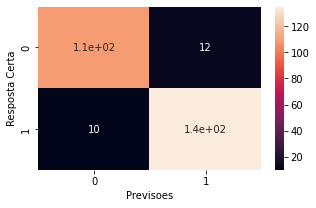

In [ ]:
matriz_MI = confusion_matrix(y_test_MI, previsoes_MI)

plt.figure(figsize = (5,3))
sns.heatmap(matriz_MI, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_MI

TP_MI = matriz_MI[0,0]
TN_MI = matriz_MI[1,1]
FP_MI = matriz_MI[1,0]
FN_MI = matriz_MI[0,1]

#Accuracy previosres/target_MI

Accuracy_MI = accuracy_score(y_test_MI, previsoes_MI) * 100

#F1_Score previsores/target_MI

F1_MI = f1_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_cvd

MCC_MI = matthews_corrcoef(y_test_MI, previsoes_MI) * 100

# Sensitivity previsores/target_cvd

sensitivity = recall_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')  * 100 # VP/(VP+FN)

# Specificity previsores/target_cvd

specificity_MI = TN_MI/(TN_MI+FP_MI) * 100

In [ ]:
print(f'Accuracy_MI: {round(Accuracy_MI,2)} %\n\nF1_MI: {round(F1_MI,2)} %\n\nMCC_MI: {round(MCC_MI,2)} %\n\nSensitivity_MI: {round(sensitivity,2)} %\n\nSpecificity_MI: {round(specificity_MI,2)} %')

Accuracy_MI: 91.76 %

F1_MI: 92.47 %

MCC_MI: 83.39 %

Sensitivity_MI: 91.76 %

Specificity_MI: 93.1 %


**Treinando previsores_ANGINA / target_ANGINA com RandomForestClassifier**

In [ ]:
modeloRandom.fit(X_train_ANGINA, y_train_ANGINA)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
previsoes_ANGINA = modeloRandom.predict(X_test_ANGINA)

Text(24.0, 0.5, 'Resposta Certa')

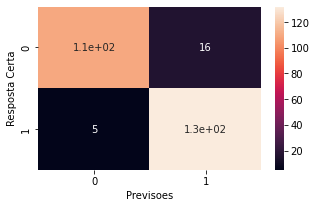

In [ ]:
matriz_ANGINA = confusion_matrix(y_test_ANGINA, previsoes_ANGINA)

plt.figure(figsize = (5,3))
sns.heatmap(matriz_ANGINA, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_ANGINA = matriz_ANGINA[0,0]
TN_ANGINA = matriz_ANGINA[1,1]
FP_ANGINA = matriz_ANGINA[1,0]
FN_ANGINA = matriz_ANGINA[0,1]

#Accuracy previosres/target_ANGINA

Accuracy_ANGINA = accuracy_score(y_test_ANGINA, previsoes_ANGINA) * 100

#F1_Score previsores/target_ANGINA

F1_ANGINA = f1_score(y_test_ANGINA, previsoes_ANGINA, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_AGINA

MCC_ANGINA = matthews_corrcoef(y_test_ANGINA, previsoes_ANGINA) * 100

# Sensitivity previsores/target_ANGINA

sensitivity_ANGINA = recall_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')  * 100 # VP/(VP+FN)

# Specificity previsores/target_ANGINA

specificity_ANGINA = TN_ANGINA/(TN_ANGINA+FP_ANGINA) * 100

In [ ]:
print(f'Accuracy_ANGINA: {round(Accuracy_ANGINA,2)} %\n\nF1_ANGINA: {round(F1_ANGINA,2)} %\n\nMCC_ANGINA: {round(MCC_ANGINA,2)} %\n\nSensitivity_ANGINA: {round(sensitivity,2)} %\n\nSpecificity_ANGINA: {round(specificity_ANGINA,2)} %')

Accuracy_ANGINA: 92.02 %

F1_ANGINA: 92.63 %

MCC_ANGINA: 84.24 %

Sensitivity_ANGINA: 91.76 %

Specificity_ANGINA: 96.35 %


**Treinando previsores_STROKE / target_STROKE com RandomForestClassifier**

In [ ]:
modeloRandom.fit(X_train_STROKE, y_train_STROKE)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
previsoes_STROKE = modeloRandom.predict(X_test_STROKE)

Text(24.0, 0.5, 'Resposta Certa')

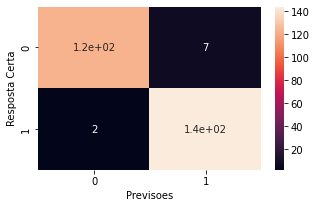

In [ ]:
matriz_STROKE = confusion_matrix(y_test_STROKE, previsoes_STROKE)

plt.figure(figsize = (5,3))
sns.heatmap(matriz_STROKE, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_STROKE = matriz_STROKE[0,0]
TN_STROKE = matriz_STROKE[1,1]
FP_STROKE = matriz_STROKE[1,0]
FN_STROKE = matriz_STROKE[0,1]

#Accuracy previosres/target_ANGINA

Accuracy_STROKE = accuracy_score(y_test_STROKE, previsoes_STROKE) * 100

#F1_Score previsores/target_STROKE

F1_STROKE = f1_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_STROKE

MCC_STROKE = matthews_corrcoef(y_test_STROKE, previsoes_STROKE) * 100

# Sensitivity previsores/target_STROKE

sensitivity = recall_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') * 100 # VP/(VP+FN)

# Specificity previsores/target_STROKE

specificity_STROKE = TN_STROKE/(TN_STROKE+FP_STROKE) * 100

In [ ]:
print(f'Accuracy_STROKE: {round(Accuracy_STROKE,2)} %\n\nF1_STROKE: {round(F1_STROKE,)} %\n\nMCC_STROKE: {round(MCC_STROKE,2)} %\n\nSensitivity_STROKE: {round(sensitivity,2)} %\n\nSpecificity_STROKE: {round(specificity_STROKE,2)} %')

Accuracy_STROKE: 96.74 %

F1_STROKE: 97 %

MCC_STROKE: 93.5 %

Sensitivity_STROKE: 96.74 %

Specificity_STROKE: 98.63 %


**Instânciando o algoritmo KNeighborsClassifier**

In [ ]:
modeloK = KNeighborsClassifier()

**Treinando o Dataset com o algoritmo KNeighborsClassifier tendo como coluna a ser prevista a target_cvd**

In [ ]:
modeloK.fit(X_train_cvd, y_train_cvd)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
previsoes_cvd = modeloK.predict(X_test_cvd)

Text(24.0, 0.5, 'Resposta Certa')

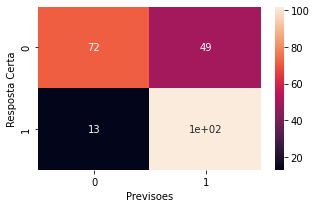

In [ ]:
# Matriz de confusão target_cvd

matriz_cvd = confusion_matrix(y_test_cvd, previsoes_cvd)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_cvd, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_cvd

TP_cvd = matriz_cvd[0,0]
TN_cvd = matriz_cvd[1,1]
FP_cvd = matriz_cvd[1,0]
FN_cvd = matriz_cvd[0,1]

#Accuracy previosres/target_cvd

Accuracy_cvd = accuracy_score(y_test_cvd, previsoes_cvd) * 100

#F1_Score previsores/target_cvd

F1_cvd = f1_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_cvd

MCC_cvd = matthews_corrcoef(y_test_cvd, previsoes_cvd) * 100

# Sensitivity previsores/target_cvd

sensitivity = recall_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') * 100 # VP/(VP+FN)

# Specificity previsores/target_cvd

specificity_cvd = TN_cvd/(TN_cvd+FP_cvd) * 100

In [ ]:
print(f'Accuracy_cvd: {round(Accuracy_cvd,2)} %\n\nF1_cvd: {round(F1_cvd,2)} %\n\nMCC_cvd: {round(MCC_cvd,2)} %\n\nSensitivity_cvd: {round(sensitivity,2)} %\n\nSpecificity_cvd: {round(specificity_cvd,2)} %')

Accuracy_cvd: 73.73 %

F1_cvd: 76.69 %

MCC_cvd: 50.19 %

Sensitivity_cvd: 73.73 %

Specificity_cvd: 88.7 %


**Treinando o Dataset com o algoritmo KNeighborsClassifier tendo como coluna a ser prevista a target_MI**

In [ ]:
modeloK.fit(X_train_MI, y_train_MI)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
previsoes_MI = modeloK.predict(X_test_MI)

Text(24.0, 0.5, 'Resposta Certa')

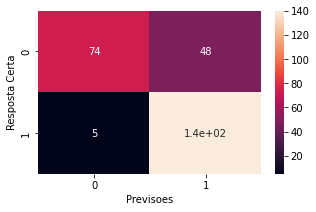

In [ ]:
# Matriz de confusão target_MI

matriz_MI = confusion_matrix(y_test_MI, previsoes_MI)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_MI, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_MI

TP_MI = matriz_MI[0,0]
TN_MI = matriz_MI[1,1]
FP_MI = matriz_MI[1,0]
FN_MI = matriz_MI[0,1]

#Accuracy previosres/target_MI

Accuracy_MI = accuracy_score(y_test_MI, previsoes_MI) * 100

#F1_Score previsores/target_MI

F1_MI = f1_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_cvd

MCC_MI = matthews_corrcoef(y_test_MI, previsoes_MI) * 100

# Sensitivity previsores/target_cvd

sensitivity = recall_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')  * 100 # VP/(VP+FN)

# Specificity previsores/target_cvd

specificity_MI = TN_MI/(TN_MI+FP_MI) * 100

In [ ]:
print(f'Accuracy_MI: {round(Accuracy_MI,2)} %\n\nF1_MI: {round(F1_MI,2)} %\n\nMCC_MI: {round(MCC_MI,2)} %\n\nSensitivity_MI: {round(sensitivity,2)} %\n\nSpecificity_MI: {round(specificity_MI,2)} %')

Accuracy_MI: 80.15 %

F1_MI: 84.08 %

MCC_MI: 62.43 %

Sensitivity_MI: 80.15 %

Specificity_MI: 96.55 %


**Treinando o Dataset com o algoritmo KNeighborsClassifier tendo como coluna a ser prevista a target_ANGINA**


In [ ]:
modeloK.fit(X_train_ANGINA, y_train_ANGINA)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
previsoes_ANGINA = modeloK.predict(X_test_ANGINA)

Text(24.0, 0.5, 'Resposta Certa')

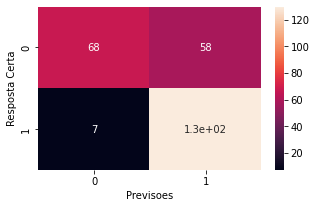

In [ ]:
# Matriz de confusão target_ANGINA

matriz_ANGINA = confusion_matrix(y_test_ANGINA, previsoes_ANGINA)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_ANGINA, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_ANGINA = matriz_ANGINA[0,0]
TN_ANGINA = matriz_ANGINA[1,1]
FP_ANGINA = matriz_ANGINA[1,0]
FN_ANGINA = matriz_ANGINA[0,1]

#Accuracy previosres/target_ANGINA

Accuracy_ANGINA = accuracy_score(y_test_ANGINA, previsoes_ANGINA) * 100

#F1_Score previsores/target_ANGINA

F1_ANGINA = f1_score(y_test_ANGINA, previsoes_ANGINA, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_AGINA

MCC_ANGINA = matthews_corrcoef(y_test_ANGINA, previsoes_ANGINA) * 100

# Sensitivity previsores/target_ANGINA

sensitivity_ANGINA = recall_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')  * 100 # VP/(VP+FN)

# Specificity previsores/target_ANGINA

specificity_ANGINA = TN_ANGINA/(TN_ANGINA+FP_ANGINA) * 100

In [ ]:
print(f'Accuracy_ANGINA: {round(Accuracy_ANGINA,2)} %\n\nF1_ANGINA: {round(F1_ANGINA,2)} %\n\nMCC_ANGINA: {round(MCC_ANGINA,2)} %\n\nSensitivity_ANGINA: {round(sensitivity,2)} %\n\nSpecificity_ANGINA: {round(specificity_ANGINA,2)} %')

Accuracy_ANGINA: 75.29 %

F1_ANGINA: 80.0 %

MCC_ANGINA: 54.06 %

Sensitivity_ANGINA: 80.15 %

Specificity_ANGINA: 94.89 %


**Treinando o Dataset com o algoritmo KNeighborsClassifier tendo como coluna a ser prevista a target_ANGINA**

In [ ]:
modeloK.fit(X_train_STROKE, y_train_STROKE)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
previsoes_STROKE = modeloK.predict(X_test_STROKE)

Text(24.0, 0.5, 'Resposta Certa')

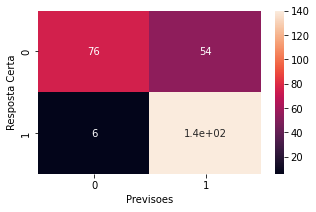

In [ ]:
# Matriz de confusão target_STROKE

matriz_STROKE = confusion_matrix(y_test_STROKE, previsoes_STROKE)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_STROKE, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_STROKE = matriz_STROKE[0,0]
TN_STROKE = matriz_STROKE[1,1]
FP_STROKE = matriz_STROKE[1,0]
FN_STROKE = matriz_STROKE[0,1]

#Accuracy previosres/target_ANGINA

Accuracy_STROKE = accuracy_score(y_test_STROKE, previsoes_STROKE) * 100

#F1_Score previsores/target_STROKE

F1_STROKE = f1_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_STROKE

MCC_STROKE = matthews_corrcoef(y_test_STROKE, previsoes_STROKE) * 100

# Sensitivity previsores/target_STROKE

sensitivity = recall_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') * 100 # VP/(VP+FN)

# Specificity previsores/target_STROKE

specificity_STROKE = TN_STROKE/(TN_STROKE+FP_STROKE) * 100

In [ ]:
print(f'Accuracy_STROKE: {round(Accuracy_STROKE,2)} %\n\nF1_STROKE: {round(F1_STROKE,)} %\n\nMCC_STROKE: {round(MCC_STROKE,2)} %\n\nSensitivity_STROKE: {round(sensitivity,2)} %\n\nSpecificity_STROKE: {round(specificity_STROKE,2)} %')

Accuracy_STROKE: 78.26 %

F1_STROKE: 82 %

MCC_STROKE: 59.37 %

Sensitivity_STROKE: 78.26 %

Specificity_STROKE: 95.89 %


**Implementação do modelo de Rede Neural com camadas ocultas**

In [ ]:
#Criação da rede neural

modelo = Sequential()

In [ ]:
#Adicionando as camadas da Rede Neural

modelo.add(Dense(units=8, activation='relu', input_dim = 15)) # Camada de entrada
modelo.add(Dropout(0.3))

modelo.add(Dense(units=8, activation='relu')) # Camada oculta
modelo.add(Dropout(0.2))

modelo.add(Dense(units=8, activation='relu')) # Camada oculta
modelo.add(Dropout(0.2))

modelo.add(Dense(units=1, activation='sigmoid')) # Camada de saída

In [ ]:
#Compilando a Rede Neural

modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

**Treinando a rede neural com as bases previsores/target_cvd**

In [ ]:
#Efetuando o treinamento da Rede Neural

modelo.fit(X_train_cvd, y_train_cvd, epochs=100, batch_size=10)

#Realizando previsão com a base de dado de teste

previsoes_cvd = modelo.predict(X_test_cvd)

#Convertendo os resultados em True ou False

previsoes_cvd = (previsoes_cvd > 0.5)

Epoch 1/100
95/95 [==============================] - 1s 1ms/step - loss: 21.7432 - binary_accuracy: 0.5191
Epoch 2/100
95/95 [==============================] - 0s 1ms/step - loss: 7.0845 - binary_accuracy: 0.5021
Epoch 3/100
95/95 [==============================] - 0s 1ms/step - loss: 4.0371 - binary_accuracy: 0.4809
Epoch 4/100
95/95 [==============================] - 0s 1ms/step - loss: 1.9419 - binary_accuracy: 0.4831
Epoch 5/100
95/95 [==============================] - 0s 1ms/step - loss: 1.7011 - binary_accuracy: 0.5064
Epoch 6/100
95/95 [==============================] - 0s 1ms/step - loss: 1.2461 - binary_accuracy: 0.5244
Epoch 7/100
95/95 [==============================] - 0s 1ms/step - loss: 0.9324 - binary_accuracy: 0.5265
Epoch 8/100
95/95 [==============================] - 0s 1ms/step - loss: 0.8907 - binary_accuracy: 0.5169
Epoch 9/100
95/95 [==============================] - 0s 2ms/step - loss: 0.8701 - binary_accuracy: 0.5222
Epoch 10/100
95/95 [=========================

Text(24.0, 0.5, 'Resposta Certa')

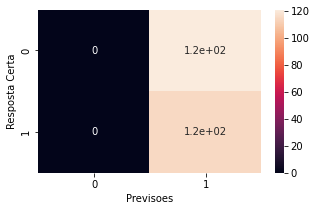

In [ ]:
# Matriz de confusão target_cvd

matriz_cvd = confusion_matrix(y_test_cvd, previsoes_cvd)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_cvd, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_cvd

TP_cvd = matriz_cvd[0,0]
TN_cvd = matriz_cvd[1,1]
FP_cvd = matriz_cvd[1,0]
FN_cvd = matriz_cvd[0,1]

#Accuracy previosres/target_cvd

Accuracy_cvd = accuracy_score(y_test_cvd, previsoes_cvd) * 100

#F1_Score previsores/target_cvd

F1_cvd = f1_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_cvd

MCC_cvd = matthews_corrcoef(y_test_cvd, previsoes_cvd) * 100

# Sensitivity previsores/target_cvd

sensitivity = recall_score(y_test_cvd, previsoes_cvd, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') * 100 # VP/(VP+FN)

# Specificity previsores/target_cvd

specificity_cvd = TN_cvd/(TN_cvd+FP_cvd) * 100

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
print(f'Accuracy_cvd: {round(Accuracy_cvd,2)} %\n\nF1_cvd: {round(F1_cvd,2)} %\n\nMCC_cvd: {round(MCC_cvd,2)} %\n\nSensitivity_cvd: {round(sensitivity,2)} %\n\nSpecificity_cvd: {round(specificity_cvd,2)} %')

Accuracy_cvd: 48.73 %

F1_cvd: 65.53 %

MCC_cvd: 0.0 %

Sensitivity_cvd: 48.73 %

Specificity_cvd: 100.0 %


**Treinando a rede neural com as bases previsores/target_MI**

In [ ]:
#Efetuando o treinamento da Rede Neural

modelo.fit(X_train_MI, y_train_MI, epochs=100, batch_size=10)

#Realizando previsão com a base de dado de teste

previsoes_MI = modelo.predict(X_test_MI)

#Convertendo os resultados em True ou False

previsoes_MI = (previsoes_MI > 0.5)

Epoch 1/100
107/107 [==============================] - 0s 2ms/step - loss: 0.6872 - binary_accuracy: 0.5427
Epoch 2/100
107/107 [==============================] - 0s 1ms/step - loss: 0.6885 - binary_accuracy: 0.5418
Epoch 3/100
107/107 [==============================] - 0s 1ms/step - loss: 0.6866 - binary_accuracy: 0.5437
Epoch 4/100
107/107 [==============================] - 0s 2ms/step - loss: 0.6848 - binary_accuracy: 0.5427
Epoch 5/100
107/107 [==============================] - 0s 2ms/step - loss: 0.6833 - binary_accuracy: 0.5437
Epoch 6/100
107/107 [==============================] - 0s 2ms/step - loss: 0.6835 - binary_accuracy: 0.5427
Epoch 7/100
107/107 [==============================] - 0s 1ms/step - loss: 0.6890 - binary_accuracy: 0.5418
Epoch 8/100
107/107 [==============================] - 0s 1ms/step - loss: 0.6868 - binary_accuracy: 0.5427
Epoch 9/100
107/107 [==============================] - 0s 2ms/step - loss: 0.6799 - binary_accuracy: 0.5427
Epoch 10/100
107/107 [======

Text(24.0, 0.5, 'Resposta Certa')

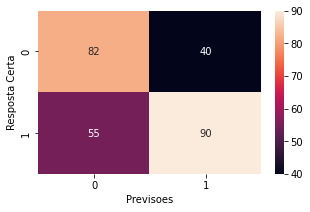

In [ ]:
# Matriz de confusão target_MI

matriz_MI = confusion_matrix(y_test_MI, previsoes_MI)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_MI, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_MI

TP_MI = matriz_MI[0,0]
TN_MI = matriz_MI[1,1]
FP_MI = matriz_MI[1,0]
FN_MI = matriz_MI[0,1]

#Accuracy previosres/target_MI

Accuracy_MI = accuracy_score(y_test_MI, previsoes_MI) * 100

#F1_Score previsores/target_MI

F1_MI = f1_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_cvd

MCC_MI = matthews_corrcoef(y_test_MI, previsoes_MI) * 100

# Sensitivity previsores/target_cvd

sensitivity = recall_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')  * 100 # VP/(VP+FN)

# Specificity previsores/target_cvd

specificity_MI = TN_MI/(TN_MI+FP_MI) * 100

In [ ]:
print(f'Accuracy_MI: {round(Accuracy_MI,2)} %\n\nF1_MI: {round(F1_MI,2)} %\n\nMCC_MI: {round(MCC_MI,2)} %\n\nSensitivity_MI: {round(sensitivity,2)} %\n\nSpecificity_MI: {round(specificity_MI,2)} %')

Accuracy_MI: 64.42 %

F1_MI: 65.45 %

MCC_MI: 29.18 %

Sensitivity_MI: 64.42 %

Specificity_MI: 62.07 %


**Treinando a rede neural com as bases previsores/target_ANGINA**

In [ ]:
#Efetuando o treinamento da Rede Neural

modelo.fit(X_train_ANGINA, y_train_ANGINA, epochs=100, batch_size=10)

#Realizando previsão com a base de dado de teste

previsoes_ANGINA = modelo.predict(X_test_ANGINA)

#Convertendo os resultados em True ou False

previsoes_ANGINA = (previsoes_ANGINA > 0.5)

Epoch 1/100
105/105 [==============================] - 0s 2ms/step - loss: 0.7030 - binary_accuracy: 0.4900
Epoch 2/100
105/105 [==============================] - 0s 1ms/step - loss: 0.7061 - binary_accuracy: 0.4852
Epoch 3/100
105/105 [==============================] - 0s 1ms/step - loss: 0.6968 - binary_accuracy: 0.4824
Epoch 4/100
105/105 [==============================] - 0s 1ms/step - loss: 0.6911 - binary_accuracy: 0.4843
Epoch 5/100
105/105 [==============================] - 0s 1ms/step - loss: 0.6875 - binary_accuracy: 0.5348
Epoch 6/100
105/105 [==============================] - 0s 2ms/step - loss: 0.6803 - binary_accuracy: 0.5529
Epoch 7/100
105/105 [==============================] - 0s 2ms/step - loss: 0.6849 - binary_accuracy: 0.5586
Epoch 8/100
105/105 [==============================] - 0s 1ms/step - loss: 0.6798 - binary_accuracy: 0.5577
Epoch 9/100
105/105 [==============================] - 0s 1ms/step - loss: 0.6785 - binary_accuracy: 0.5605
Epoch 10/100
105/105 [======

Text(24.0, 0.5, 'Resposta Certa')

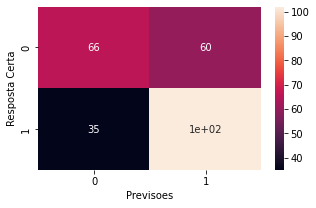

In [ ]:
# Matriz de confusão target_ANGINA

matriz_ANGINA = confusion_matrix(y_test_ANGINA, previsoes_ANGINA)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_ANGINA, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_ANGINA = matriz_ANGINA[0,0]
TN_ANGINA = matriz_ANGINA[1,1]
FP_ANGINA = matriz_ANGINA[1,0]
FN_ANGINA = matriz_ANGINA[0,1]

#Accuracy previosres/target_ANGINA

Accuracy_ANGINA = accuracy_score(y_test_ANGINA, previsoes_ANGINA) * 100

#F1_Score previsores/target_ANGINA

F1_ANGINA = f1_score(y_test_ANGINA, previsoes_ANGINA, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_AGINA

MCC_ANGINA = matthews_corrcoef(y_test_ANGINA, previsoes_ANGINA) * 100

# Sensitivity previsores/target_ANGINA

sensitivity_ANGINA = recall_score(y_test_MI, previsoes_MI, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')  * 100 # VP/(VP+FN)

# Specificity previsores/target_ANGINA

specificity_ANGINA = TN_ANGINA/(TN_ANGINA+FP_ANGINA) * 100

In [ ]:
print(f'Accuracy_ANGINA: {round(Accuracy_ANGINA,2)} %\n\nF1_ANGINA: {round(F1_ANGINA,2)} %\n\nMCC_ANGINA: {round(MCC_ANGINA,2)} %\n\nSensitivity_ANGINA: {round(sensitivity,2)} %\n\nSpecificity_ANGINA: {round(specificity_ANGINA,2)} %')

Accuracy_ANGINA: 63.88 %

F1_ANGINA: 68.23 %

MCC_ANGINA: 27.56 %

Sensitivity_ANGINA: 64.42 %

Specificity_ANGINA: 74.45 %


**Treinando a rede neural com as bases previsores/target_STROKE**

In [ ]:
#Efetuando o treinamento da Rede Neural

modelo.fit(X_train_STROKE, y_train_STROKE, epochs=100, batch_size=10)

#Realizando previsão com a base de dado de teste

previsoes_STROKE = modelo.predict(X_test_STROKE)

#Convertendo os resultados em True ou False

previsoes_STROKE = (previsoes_STROKE > 0.5)

Epoch 1/100
111/111 [==============================] - 0s 1ms/step - loss: 0.7044 - binary_accuracy: 0.5318
Epoch 2/100
111/111 [==============================] - 0s 1ms/step - loss: 0.6942 - binary_accuracy: 0.5254
Epoch 3/100
111/111 [==============================] - 0s 1ms/step - loss: 0.6898 - binary_accuracy: 0.5218
Epoch 4/100
111/111 [==============================] - 0s 2ms/step - loss: 0.6846 - binary_accuracy: 0.5336
Epoch 5/100
111/111 [==============================] - 0s 1ms/step - loss: 0.6795 - binary_accuracy: 0.5572
Epoch 6/100
111/111 [==============================] - 0s 2ms/step - loss: 0.6837 - binary_accuracy: 0.5563
Epoch 7/100
111/111 [==============================] - 0s 2ms/step - loss: 0.6825 - binary_accuracy: 0.5554
Epoch 8/100
111/111 [==============================] - 0s 1ms/step - loss: 0.6820 - binary_accuracy: 0.5581
Epoch 9/100
111/111 [==============================] - 0s 1ms/step - loss: 0.6769 - binary_accuracy: 0.5599
Epoch 10/100
111/111 [======

Text(24.0, 0.5, 'Resposta Certa')

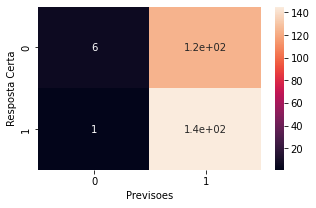

In [ ]:
# Matriz de confusão target_STROKE

matriz_STROKE = confusion_matrix(y_test_STROKE, previsoes_STROKE)
plt.figure(figsize = (5,3))
sns.heatmap(matriz_STROKE, annot = True)
plt.xlabel("Previsoes")
plt.ylabel("Resposta Certa")

In [ ]:
#Separando os valores TP-TN-FP-FN previosres/target_ANGINA

TP_STROKE = matriz_STROKE[0,0]
TN_STROKE = matriz_STROKE[1,1]
FP_STROKE = matriz_STROKE[1,0]
FN_STROKE = matriz_STROKE[0,1]

#Accuracy previosres/target_ANGINA

Accuracy_STROKE = accuracy_score(y_test_STROKE, previsoes_STROKE) * 100

#F1_Score previsores/target_STROKE

F1_STROKE = f1_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn') * 100

#MCC_Score previsores/target_STROKE

MCC_STROKE = matthews_corrcoef(y_test_STROKE, previsoes_STROKE) * 100

# Sensitivity previsores/target_STROKE

sensitivity = recall_score(y_test_STROKE, previsoes_STROKE, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn') * 100 # VP/(VP+FN)

# Specificity previsores/target_STROKE

specificity_STROKE = TN_STROKE/(TN_STROKE+FP_STROKE) * 100

In [ ]:
print(f'Accuracy_STROKE: {round(Accuracy_STROKE,2)}\n\nF1_STROKE: {round(F1_STROKE,)} %\n\nMCC_STROKE: {round(MCC_STROKE,2)} %\n\nSensitivity_STROKE: {round(sensitivity,2)} %\n\nSpecificity_STROKE: {round(specificity_STROKE,2)} %')

Accuracy_STROKE: 54.71

F1_STROKE: 70 %

MCC_STROKE: 12.48 %

Sensitivity_STROKE: 54.71 %

Specificity_STROKE: 99.32 %


**Validação Cruzada**

In [ ]:
#Definindo os valores para folds

num_folds = 10
seed = 7

#Separando os dados em folds

Kfold = KFold(num_folds, True, random_state= seed) 

**Validação Cruzada com algoritomo RandomForestClassifier**

In [ ]:
#Criando o modelo

modeloRandomValCru = RandomForestClassifier()

**Validação Cruzada com algoritomo RandomForestClassifier usando previsores_cvd / target_cvd**

In [ ]:
#Aplicando a validação cruzada previsores_cvd/target_cvd

resultados_acc_cvd = cross_val_score(modeloRandomValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='accuracy')
resultados_f1_cvd = cross_val_score(modeloRandomValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='f1')
resultados_recall_cvd = cross_val_score(modeloRandomValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='recall')
resultados_precision_cvd = cross_val_score(modeloRandomValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='precision')

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_cvd = resultados_acc_cvd.mean() * 100
resultados_f1_cvd = resultados_f1_cvd.mean() * 100
resultados_recall_cvd = resultados_recall_cvd.mean() * 100
resultados_precision_cvd = resultados_precision_cvd.mean() * 100

print(f'Accuracy: {round(resultados_acc_cvd,2)} %\n\nF1: {round(resultados_f1_cvd,2)} %\n\nSensibility: {round(resultados_recall_cvd,2)} %\n\nPrecision: {round(resultados_precision_cvd,2)} %')

Accuracy: 85.26 %

F1: 86.67 %

Sensibility: 88.64 %

Precision: 83.1 %


**Validação Cruzada  com algoritomo RandomForestClassifier usando previsores_MI / target_MI**

In [ ]:
#Aplicando a validação cruzada previsores_MI/target_MI

resultados_acc_MI = cross_val_score(modeloRandomValCru, previsores_MI, target_MI, cv=Kfold, scoring='accuracy')
resultados_f1_MI = cross_val_score(modeloRandomValCru, previsores_MI, target_MI, cv=Kfold, scoring='f1')
resultados_recall_MI = cross_val_score(modeloRandomValCru, previsores_MI, target_MI, cv=Kfold, scoring='recall')
resultados_precision_MI = cross_val_score(modeloRandomValCru, previsores_MI, target_MI, cv=Kfold, scoring='precision')

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_MI = resultados_acc_MI.mean() * 100
resultados_f1_MI = resultados_f1_MI.mean() * 100
resultados_recall_MI = resultados_recall_MI.mean() * 100
resultados_precision_MI = resultados_precision_MI.mean() * 100

print(f'Accuracy: {round(resultados_acc_MI,2)} %\n\nF1: {round(resultados_f1_MI,2)} %\n\nSensibility: {round(resultados_recall_MI,2)} %\n\nPrecision: {round(resultados_precision_MI,2)} %')

Accuracy: 93.4 %

F1: 93.72 %

Sensibility: 96.56 %

Precision: 91.1 %


**Validação Cruzada  com algoritomo RandomForestClassifier usando previsores_ANGINA / target_ANGINA**

In [ ]:
#Aplicando a validação cruzada previsores_ANGINA/target_ANGINA

resultados_acc_ANGINA = cross_val_score(modeloRandomValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='accuracy')
resultados_f1_ANGINA = cross_val_score(modeloRandomValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='f1')
resultados_recall_ANGINA = cross_val_score(modeloRandomValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='recall')
resultados_precision_ANGINA = cross_val_score(modeloRandomValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='precision')

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_ANGINA = resultados_acc_ANGINA.mean() * 100
resultados_f1_ANGINA = resultados_f1_ANGINA.mean() * 100
resultados_recall_ANGINA = resultados_recall_ANGINA.mean() * 100
resultados_precision_ANGINA = resultados_precision_ANGINA.mean() * 100

print(f'Accuracy: {round(resultados_acc_ANGINA,2)} %\n\nF1: {round(resultados_f1_ANGINA,2)} %\n\nSensibility: {round(resultados_recall_ANGINA,2)} %\n\nPrecision: {round(resultados_precision_ANGINA,2)} %')

Accuracy: 91.99 %

F1: 92.72 %

Sensibility: 95.72 %

Precision: 90.22 %


**Validação Cruzada  com algoritomo RandomForestClassifier usando previsores_STROKE / target_STROKE**

In [ ]:
#Aplicando a validação cruzada previsores_STROKE/target_STROKE

resultados_acc_STROKE = cross_val_score(modeloRandomValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='accuracy')
resultados_f1_STROKE = cross_val_score(modeloRandomValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='f1')
resultados_recall_STROKE = cross_val_score(modeloRandomValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='recall')
resultados_precision_STROKE = cross_val_score(modeloRandomValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='precision')

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_STROKE = resultados_acc_STROKE.mean() * 100
resultados_f1_STROKE = resultados_f1_STROKE.mean() * 100
resultados_recall_STROKE = resultados_recall_STROKE.mean() * 100
resultados_precision_STROKE = resultados_precision_STROKE.mean() * 100

print(f'Accuracy: {round(resultados_acc_STROKE,2)} %\n\nF1: {round(resultados_f1_STROKE,2)} %\n\nSensibility: {round(resultados_recall_STROKE,2)} %\n\nPrecision: {round(resultados_precision_STROKE,2)} %')

Accuracy: 95.79 %

F1: 96.14 %

Sensibility: 97.95 %

Precision: 94.53 %


**Validação Cruzada com algoritomo KNeighborsClassifier**

In [ ]:
#Criando o modelo

modeloKValCru = KNeighborsClassifier()

**Validação Cruzada com algoritomo KNeighborsClassifier usando previsores_cvd / target_cvd**

In [ ]:
#Aplicando a validação cruzada previsores_cvd/target_cvd

resultados_acc_cvd = cross_val_score(modeloKValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='accuracy')
resultados_f1_cvd = cross_val_score(modeloKValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='f1')
resultados_recall_cvd = cross_val_score(modeloKValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='recall')
resultados_precision_cvd = cross_val_score(modeloKValCru, previsores_cvd, target_cvd, cv=Kfold, scoring='precision')

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_cvd = resultados_acc_cvd.mean() * 100
resultados_f1_cvd = resultados_f1_cvd.mean() * 100
resultados_recall_cvd = resultados_recall_cvd.mean() * 100
resultados_precision_cvd = resultados_precision_cvd.mean() * 100

print(f'Accuracy: {round(resultados_acc_cvd,2)} %\n\nF1: {round(resultados_f1_cvd,2)} %\n\nSensibility: {round(resultados_recall_cvd,2)} %\n\nPrecision: {round(resultados_precision_cvd,2)} %')

Accuracy: 75.09 %

F1: 78.94 %

Sensibility: 92.7 %

Precision: 69.56 %


**Validação Cruzada com algoritomo KNeighborsClassifier usando previsores_MI / target_MI**

In [ ]:
#Aplicando a validação cruzada previsores_MI/target_MI

resultados_acc_MI = cross_val_score(modeloKValCru, previsores_MI, target_MI, cv=Kfold, scoring='accuracy')
resultados_f1_MI = cross_val_score(modeloKValCru, previsores_MI, target_MI, cv=Kfold, scoring='f1')
resultados_recall_MI = cross_val_score(modeloKValCru, previsores_MI, target_MI, cv=Kfold, scoring='recall')
resultados_precision_MI = cross_val_score(modeloKValCru, previsores_MI, target_MI, cv=Kfold, scoring='precision')

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_MI = resultados_acc_MI.mean() * 100
resultados_f1_MI = resultados_f1_MI.mean() * 100
resultados_recall_MI = resultados_recall_MI.mean() * 100
resultados_precision_MI = resultados_precision_MI.mean() * 100

print(f'Accuracy: {round(resultados_acc_MI,2)} %\n\nF1: {round(resultados_f1_MI,2)} %\n\nSensibility: {round(resultados_recall_MI,2)} %\n\nPrecision: {round(resultados_precision_MI,2)} %')

Accuracy: 81.48 %

F1: 84.53 %

Sensibility: 96.12 %

Precision: 76.0 %


**Validação Cruzada com algoritomo KNeighborsClassifier usando previsores_ANGINA / target_ANGINA**

In [ ]:
#Aplicando a validação cruzada previsores_ANGINA/target_ANGINA

resultados_acc_ANGINA = cross_val_score(modeloKValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='accuracy')
resultados_f1_ANGINA = cross_val_score(modeloKValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='f1')
resultados_recall_ANGINA = cross_val_score(modeloKValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='recall')
resultados_precision_ANGINA = cross_val_score(modeloKValCru, previsores_ANGINA, target_ANGINA, cv=Kfold, scoring='precision')

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_ANGINA = resultados_acc_ANGINA.mean() * 100
resultados_f1_ANGINA = resultados_f1_ANGINA.mean() * 100
resultados_recall_ANGINA = resultados_recall_ANGINA.mean() * 100
resultados_precision_ANGINA = resultados_precision_ANGINA.mean() * 100

print(f'Accuracy: {round(resultados_acc_ANGINA,2)} %\n\nF1: {round(resultados_f1_ANGINA,2)} %\n\nSensibility: {round(resultados_recall_ANGINA,2)} %\n\nPrecision: {round(resultados_precision_ANGINA,2)} %')

Accuracy: 78.81 %

F1: 82.97 %

Sensibility: 96.2 %

Precision: 73.22 %


**Validação Cruzada com algoritomo KNeighborsClassifier usando previsores_STROKE / target_STROKE**

In [ ]:
#Aplicando a validação cruzada previsores_STROKE/target_STROKE

resultados_acc_STROKE = cross_val_score(modeloKValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='accuracy')
resultados_f1_STROKE = cross_val_score(modeloKValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='f1')
resultados_recall_STROKE = cross_val_score(modeloKValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='recall')
resultados_precision_STROKE = cross_val_score(modeloKValCru, previsores_STROKE, target_STROKE, cv=Kfold, scoring='precision')

In [ ]:
#Média de accuracy, F1, Sensibility e precision após a validação cruzada

resultados_acc_STROKE = resultados_acc_STROKE.mean() * 100
resultados_f1_STROKE = resultados_f1_STROKE.mean() * 100
resultados_recall_STROKE = resultados_recall_STROKE.mean() * 100
resultados_precision_STROKE = resultados_precision_STROKE.mean() * 100

print(f'Accuracy: {round(resultados_acc_STROKE,2)} %\n\nF1: {round(resultados_f1_STROKE,2)} %\n\nSensibility: {round(resultados_recall_STROKE,2)} %\n\nPrecision: {round(resultados_precision_STROKE,2)} %')

Accuracy: 82.29 %

F1: 85.55 %

Sensibility: 97.06 %

Precision: 76.71 %
